In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import json
import talib
import mplfinance as mpf
import numpy as np
from datetime import datetime

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.select import Select
from selenium.webdriver.common.by import By

In [2]:
options = webdriver.ChromeOptions()
options.add_argument("--disable-notifications")
options.add_argument("headless")
s = Service(ChromeDriverManager().install())
chrome = webdriver.Chrome(options = options,service = s)



====== WebDriver manager ======
Current google-chrome version is 105.0.5195
Get LATEST chromedriver version for 105.0.5195 google-chrome
Driver [/home/cosbi/.wdm/drivers/chromedriver/linux64/105.0.5195.52/chromedriver] found in cache


In [3]:
chrome.get("https://goodinfo.tw/tw/ShowK_Chart.asp?STOCK_ID=%s&CHT_CAT2=%s&PRICE_ADJ=F" % ("4744", "DATE"))
s1 = Select(chrome.find_element(by = By.ID, value = 'selK_ChartPeriod'))
s1.select_by_index(2)

time.sleep(2)

In [4]:
try :
    Kline_form = chrome.find_element(by = By.ID, value = 'divPriceDetail')
except Exception:
    result = {
        "error" : "Error"
    }

    json = json.dumps(result)
    print(json)
    sys.stdout.flush()
    sys.exit()

df1 = pd.read_html(Kline_form.get_attribute('innerHTML'), header = 1)[0]
df1 = df1.drop(df1.columns[[x for x in range(5, len(df1.columns))]], axis = 1)

for i in range(len(df1)):
    if df1["交易日期"][i] == "交易日期":
        df1.drop(i, inplace = True)
df1.replace("-", 0, inplace = True)
df1.reset_index(drop = True, inplace = True)

In [5]:
tonow = datetime.now()
year = tonow.year
month = tonow.month
date = df1["交易日期"].to_list()

for i in range(len(df1)):
    if (i != 0) and (date[i][0:2] != date[i - 1][0:2]):
        month -= 1
    
        if month == 0:
            year -= 1
            month = 12
    
    df1["交易日期"][i] = datetime.strptime((str(year) +"-" + df1["交易日期"][i]).replace("/", "-") + " 08:00", "%Y-%m-%d %H:%M").timestamp() * 1000

df1 = df1.iloc[::-1]
df1.reset_index(drop = True, inplace = True)

In [6]:
pos_BIAS = []
neg_BIAS = []
support = [np.nan for i in range(20)]
resistance = [np.nan for i in range(20)]
sma_20 = talib.SMA(df1["收盤"], timeperiod = 20)

for i in range(20, len(sma_20), 1):
    temp = (float(df1["收盤"][i]) - sma_20[i]) / sma_20[i]
    
    if temp >= 0:
        pos_BIAS.append(round(float(temp), 4))
    else:
        neg_BIAS.append(round(float(temp), 4))

pos_BIAS.sort()
neg_BIAS.sort()

pos_BIAS_val = float(pos_BIAS[int(len(pos_BIAS) * 0.95) - 1])
neg_BIAS_val = float(neg_BIAS[int(len(neg_BIAS) * 0.05) - 1])

In [7]:
for i in range(20, len(sma_20), 1):
    support.append((1 + neg_BIAS_val) * sma_20[i])
    resistance.append((1 + pos_BIAS_val) * sma_20[i])

In [8]:
df1 = df1.rename(columns = {"交易日期": "Date", "開盤": "Open", "最高": "High", "最低": "Low", "收盤": "Close"})
df1.index = pd.DatetimeIndex(df1['Date'])
df1["Open"] = df1["Open"].astype(float)
df1["High"] = df1["High"].astype(float)
df1["Low"] = df1["Low"].astype(float)
df1["Close"] = df1["Close"].astype(float)

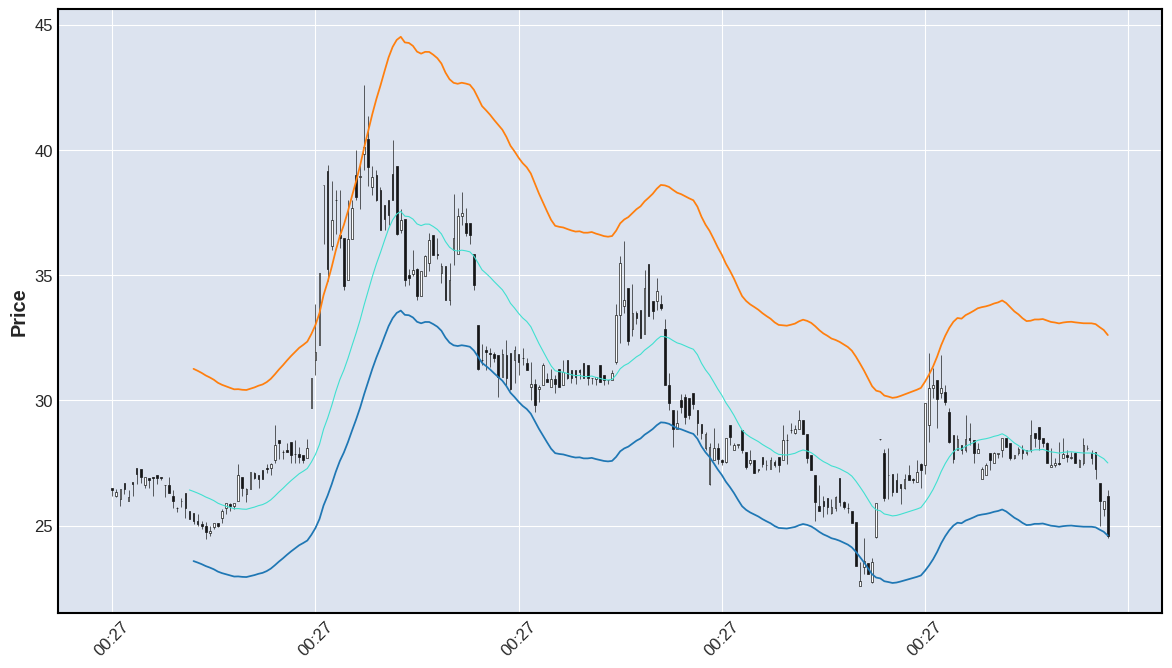

In [10]:
apds = [mpf.make_addplot(support, secondary_y = False), mpf.make_addplot(resistance, secondary_y = False)]

mpf.plot(df1, type = 'candle', addplot = apds, mav = 20, figscale = 1.5, figratio = (16,9))